In [1]:
!pip install lmfit
!pip install seaborn


You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import numpy as np
#import cv2
import os
import re
import glob
import matplotlib.pyplot as plt
from scipy.signal import  gaussian
from scipy.ndimage import filters
from scipy import optimize
from scipy.stats import linregress
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns

import scipy as sp
import scipy.interpolate
from scipy.integrate import trapz

import time

import pandas as pd

from lmfit import Model, fit_report, Parameters

#from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


######### initialize the data ###############
data_input=[]
data_output=[]
l_sample=300
vol_all=[]
vol2_all=[]
data_x=[]
data_y=[]
data_h=[]
data_w=[]
R_sph_all=[]
Ar=[]
#st_all=[]
rho=[]
theta=[]
#List of non-processed images:
discarded=[]
new=[]  #list of images without the discarded ones

#For the simple approach fit
phi_final=[]
theta_az=[]
theta_all=[]
theta_final=[]
r_theta_all=[]
xc_all=[]
yc_all=[]
rho_final=[]
data_Ps=[]
data_dB=[]
data_stderr=[]
data_err=[]

total_num_pictures = len(glob.glob1('.',"*.png"))
frame_number=np.arange(total_num_pictures)

gamma=64 #[N/m]
Cg_air=1/101325 #Pa**(-1)
k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
#Calibration
needle_d=0.83 #mm
needle_pxl=220 #pixels
#calibration=0.00621722846441948**3
cal=needle_d/needle_pxl
calibration=(cal)**3


###############################################################################
#### Functions used in the data processing ####################################
###############################################################################

def calc_volume(x,y):
    """
    Calculate the drop volume from a shape matrix.

    Parameters
    ----------
    x, y - contour of the drop

    Returns
    -------
    Integrated volume using for the given shape matrix.

    """
    # data selection
    idx=x<=0  # r=right
    x_l=x[idx]
    y_l=y[idx]
        
    vol_left=trapz(np.pi*x_l**2, y_l)/2
        
    # data selection
    idx=x>=0  # r=right
    x_r=x[idx]
    y_r=y[idx]
    vol_right=-trapz(np.pi*x_r**2, y_r)/2
   
    return vol_left+vol_right


def calc_R_sph(vol, cal):
    """
    Calculate the spherical radius of a droplet based on the volume.

    Input parameters
    ----------
    vol:         volume   [pixels**3]
    calibration: calibration factor  [mm**3/pixels**3]

    Returns
    -------
    Corresponding spherical radius.  [mm]

    """
#    calibration=0.00621722846441948**3
    #R_sph=(3*vol*calibration/(4*np.pi))**(1/3)
    R_sph=(3*vol/(4*np.pi))**(1/3)
    return R_sph

def calc_dB(Ps):
    """
    Calculate the deci Bell (dB) value for each acoustic pressure Ps.

    Input parameters
    ----------
    Ps:     aplitude of the acoustic pressure

    Returns
    -------
    dB value. []

    """
    Po=2*10**(-5) #[Pa]

    return 20*np.log10(Ps/Po)     #Acoustic pressure [Pa]

def model_fit(th, Ps):
    """
    Express the model that will be used to fit the experimental data (simple approach).

    Input parameters
    ----------
    dB:     deciBell
    th:     angle theta
    Returns
    -------
    Expression of fitting model.

    """
#    Ps=calc_ampl(dB)
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))
    return ct_new*(3*(np.cos(th))**2-1)+R_sph


def R_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph

def ST_predict(th, gamma, R_sph, Ps, Cg_air, k_o):
    """
    Prediction of ST. 
    After the acoustic pressure is determined. The ST is calculated based on the equation of our model. 
    
    
    Input parameters
    ----------
    th:     angle theta
    gamma:  ST as initial predition [mN/m]
    Power:  U*I [Watt]
    Returns
    -------
    gamma:   predicted surface tension [mN/m]

    """    
#    Ps=data_Ps[i-1]    #[Pa]
    ct_new=-((3/(64*gamma))*R_sph**2*Ps**2*Cg_air*(1+((7/5)*(k_o*R_sph)**2)))*(3*(np.cos(th))**2-1)
    return ct_new+R_sph


def azimuth(phi):
    """
    Calculate the azimuthal angle.

    Input parameters
    ----------
    phi:     angle phi

    Returns
    -------
    Azimuthal angle.

    """

    if phi<=np.pi/2:
        a=np.pi/2-phi
    else:
        a=2.5*np.pi-phi
    return a


def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return(theta, rho)

def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return(x, y)


def pol2cart_theta(rho, theta):
    x = rho * np.sin(theta)
    y = rho * np.cos(theta)
    return(x, y)

2.0.1
Num GPUs Available:  1


Generate random angle:
20 000 sets of 200 points

Radius in mm:  1060.7844179470553
(5000, 200)
(0, 200)
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
(5000, 200)
(5000, 401)
30.006102525716475
71.99433748141851


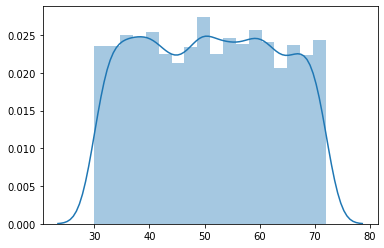

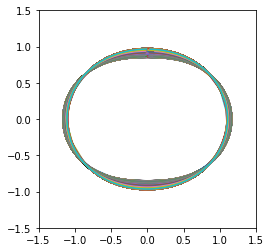

In [26]:
def gen_data(num_sample,sampling):

    np.random.seed(1234)

    #test=np.arange(100)
    #test_r=np.random.choice(test,10)

    vol_drop=5 # in µL
    calibration=0.0060567117466506235e-3 #m/px
    #calibration=1


    gamma=72.8 #[N/m]   !!!!!!!!!!!!!!!!!!!!!   there is an error here should be mN
    Cg_air=1/101325 #Pa**(-1)
    k_o=2*np.pi*40/340  #wave number in the air. frequency 40kHz (25kH=0.000040sec) and speed of sound in air v=340 m/s from paper (331.5 for 20oC online) 
    #Calibration
    Ps= 1800
    R_sph=calc_R_sph(vol_drop, calibration)

    print("Radius in mm: ", R_sph*1e3)
    
    #num_sample=200  #ST
    #sampling=200

    #theta=np.linspace(0,2*np.pi, 100)

    #theta=np.random.random(200)*2*np.pi
    theta=np.random.rand(num_sample, sampling)*2*np.pi
    theta.sort()
    ST_range=np.random.random(num_sample)*(72-30)+30
    print(theta.shape)
    r_all=np.empty([0,sampling])
    print(r_all.shape)

    for i in range(num_sample):
        r=R_predict(theta[i], ST_range[i], R_sph, Ps, Cg_air, k_o)
          #print(r.shape)
         #print(r)
        r_all=np.vstack((r_all, r))
        
        if i % 100 == 0:
                print(i)
        

    print(r_all.shape)

    dataset=np.hstack((theta,r_all, ST_range.reshape([num_sample,1])))
    print(dataset.shape)

    #print(ST_range)
    print(ST_range.min())
    print(ST_range.max())
    #sns.set(color_codes=True)
    sns.distplot(ST_range);

    fig3 = plt.figure()
    ax = plt.gca()
    ax.set_aspect(1)
    ax.set_xlim([-1.5,1.5])
    ax.set_ylim([-1.5,1.5])
    

    for j in dataset:

      x,y=pol2cart_theta(j[sampling:sampling+sampling], j[0:sampling])
    #  print(x.shape)
    #  print(y.shape)

      #plt.plot(x*1e3,y*1e3)
      plt.plot(x,y)

    plt.show()
    return dataset

num_sample=5000  # number of different ST values
sampling=200 # number of coordiante point describing the contour


dataset=gen_data(num_sample,sampling)


column_names=[]
for i in range(sampling):
  column_names.append('theta')
for i in range(sampling):
  column_names.append('rho')

column_names.append('ST')


raw_dataset = pd.DataFrame(dataset, columns=column_names)

raw_dataset.to_csv('./dataset.csv',index=False)


In [27]:
import io
#input = pd.read_csv(io.BytesIO(uploaded['data.csv']))
#input = pd.DataFrame(dataset)
# Dataset is now stored in a Pandas Dataframe
#input.size


In [28]:
# loading of data

raw_dataset=pd.read_csv('dataset.csv')

dataset = raw_dataset.copy()
dataset.tail()

,theta,theta.1,theta.2,theta.3,theta.4,theta.5,theta.6,theta.7,theta.8,theta.9,...,rho.191,rho.192,rho.193,rho.194,rho.195,rho.196,rho.197,rho.198,rho.199,ST
4995,0.033196,0.080572,0.151492,0.202281,0.238298,0.261690,0.267977,0.277648,0.330929,0.390225,...,0.958187,0.957501,0.954873,0.945921,0.945229,0.944147,0.943849,0.942074,0.941710,52.529100
4996,0.112351,0.122821,0.163990,0.173220,0.237142,0.291035,0.309880,0.356042,0.368716,0.382229,...,0.945506,0.944419,0.942451,0.942342,0.941671,0.939270,0.938898,0.938338,0.938172,51.146062
4997,0.039116,0.099112,0.104960,0.125689,0.199744,0.257138,0.267558,0.331899,0.337089,0.373073,...,0.886654,0.886601,0.885194,0.883205,0.881658,0.881231,0.880261,0.880012,0.879966,34.689841
4998,0.014346,0.036231,0.043969,0.044453,0.088801,0.130613,0.191184,0.195540,0.208702,0.412201,...,0.962360,0.959155,0.956477,0.953169,0.952645,0.952341,0.952256,0.951528,0.951170,57.194459
4999,0.039988,0.056159,0.147036,0.155008,0.170555,0.177394,0.209926,0.224403,0.230426,0.234068,...,0.969943,0.969760,0.969073,0.968779,0.967268,0.966661,0.966322,0.966144,0.966079,66.260390


### Split the data into train and test

Now split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our model.

In [29]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

In [30]:
#sns.pairplot(train_dataset[column_names], diag_kind="kde")
#plt.show()

Also look at the overall statistics:

In [31]:
train_stats = train_dataset.describe()
train_stats.pop("ST")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
theta,4000.0,0.031264,0.030949,0.000004,0.008926,0.022175,0.043417,0.242190
theta.1,4000.0,0.061806,0.042983,0.000534,0.030005,0.052550,0.082815,0.356888
theta.2,4000.0,0.092641,0.052942,0.002559,0.053188,0.083498,0.122344,0.489584
theta.3,4000.0,0.124314,0.061655,0.007941,0.078184,0.115235,0.159605,0.492807
theta.4,4000.0,0.155378,0.069801,0.016825,0.104355,0.145726,0.195939,0.559092
...,...,...,...,...,...,...,...,...
rho.195,4000.0,0.935147,0.032333,0.853411,0.911409,0.942193,0.962491,0.996416
rho.196,4000.0,0.933271,0.032638,0.852233,0.909288,0.940165,0.961023,0.996221
rho.197,4000.0,0.931776,0.032887,0.852031,0.907460,0.938899,0.959708,0.988395
rho.198,4000.0,0.930649,0.033091,0.851762,0.906163,0.937992,0.958793,0.982285


### Split features from labels

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [32]:
train_labels = train_dataset.pop('ST')
test_labels = test_dataset.pop('ST')

### Normalize the data

Look again at the `train_stats` block above and note how different the ranges of each feature are.

It is good practice to normalize features that use different scales and ranges. Although the model *might* converge without feature normalization, it makes training more difficult, and it makes the resulting model dependent on the choice of units used in the input.

Note: Although we intentionally generate these statistics from only the training dataset, these statistics will also be used to normalize the test dataset. We need to do that to project the test dataset into the same distribution that the model has been trained on.

In [33]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)


This normalized data is what we will use to train the model.

Caution: The statistics used to normalize the inputs here (mean and standard deviation) need to be applied to any other data that is fed to the model, along with the one-hot encoding that we did earlier.  That includes the test set as well as live data when the model is used in production.

## The model

### Build the model

Let's build our model. Here, we'll use a `Sequential` model with two densely connected hidden layers, and an output layer that returns a single, continuous value. The model building steps are wrapped in a function, `build_model`, since we'll create a second model, later on.

In [34]:
def build_model():
  model = keras.Sequential([
    #layers.Dense(100, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(400, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(150, activation=tf.nn.relu),
    layers.Dense(10, activation=tf.nn.relu),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.0001)

  model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
  return model

In [35]:
model = build_model()

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [36]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 400)               160400    
_________________________________________________________________
dense_13 (Dense)             (None, 150)               60150     
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1510      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 11        
Total params: 222,071
Trainable params: 222,071
Non-trainable params: 0
_________________________________________________________________



Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [37]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[ 0.03417835],
       [-0.44183064],
       [-0.19837008],
       [ 0.11806098],
       [-0.24200842],
       [-0.6259847 ],
       [ 0.24557266],
       [-0.19629729],
       [ 0.22847643],
       [-0.6765268 ]], dtype=float32)

It seems to be working, and it produces a result of the expected shape and type.

### Train the model

Train the model for 1000 epochs, and record the training and validation accuracy in the `history` object.

In [38]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 50

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[PrintDot()])


..................................................

Visualize the model's training progress using the stats stored in the `history` object.

In [39]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mean_absolute_error,mean_squared_error,val_loss,val_mean_absolute_error,val_mean_squared_error,epoch
45,1.446428,0.934788,1.446428,2.873687,1.321908,2.873687,45
46,1.291684,0.894236,1.291684,2.708628,1.274071,2.708628,46
47,1.310340,0.908394,1.310340,3.058607,1.386592,3.058608,47
48,1.232471,0.863341,1.232471,2.700927,1.262378,2.700927,48
49,1.244019,0.883154,1.244019,2.591090,1.263749,2.591089,49


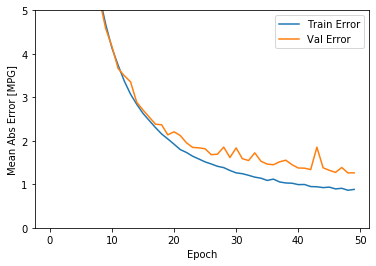

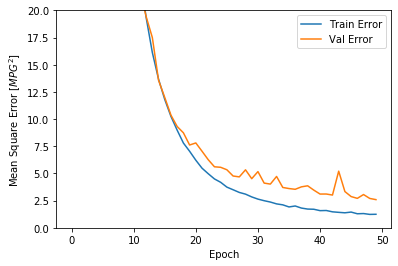

In [40]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
  plt.ylim([0,5])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()
  plt.show()


plot_history(history)

This graph shows little improvement, or even degradation in the validation error after about 100 epochs. Let's update the `model.fit` call to automatically stop training when the validation score doesn't improve. We'll use an *EarlyStopping callback* that tests a training condition for  every epoch. If a set amount of epochs elapses without showing improvement, then automatically stop the training.

You can learn more about this callback [here](https://www.tensorflow.org/versions/master/api_docs/python/tf/keras/callbacks/EarlyStopping).


............................................................................................

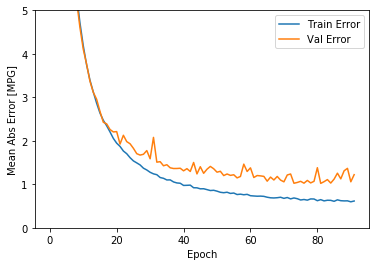

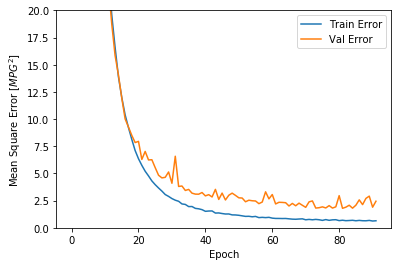

In [41]:
model = build_model()
EPOCHS=1000
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(normed_train_data, train_labels, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

The graph shows that on the validation set, the average error is usually around +/- 2 MPG. Is this good? We'll leave that decision up to you.

Let's see how well the model generalizes by using the **test** set, which we did not use when training the model.  This tells us how well we can expect the model to predict when we use it in the real world.

In [42]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} mN/m".format(mae))

Testing set Mean Abs Error:  1.25 mN/m


### Make predictions

Finally, predict volt values using data in the testing set:

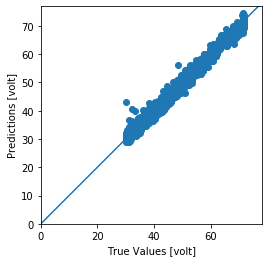

In [43]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [volt]')
plt.ylabel('Predictions [volt]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


Seriously?

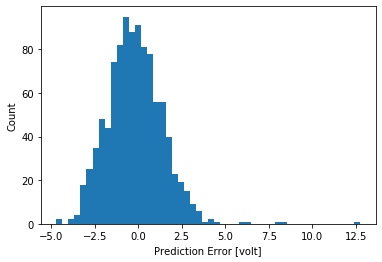

In [44]:
error = test_predictions - test_labels
plt.hist(error, bins = 50)
plt.xlabel("Prediction Error [volt]")
_ = plt.ylabel("Count")
plt.show()